<a href="https://colab.research.google.com/github/SJG0510/ML-Project/blob/main/TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

선형회귀 예측

사용 가능한 시도: 강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 제주, 충남, 충북
예측할 시도를 입력하세요: 서울
서울의 선택 가능한 시군구: 강남구, 강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 송파구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중구, 중랑구
예측할 시군구를 입력하세요: 강남구
결정계수(R²): 0.603
평균제곱오차(MSE): 0.236

실제 (2008~2024):
2008년: 4.4%
2009년: 6.0%
2010년: 6.3%
2011년: 7.2%
2012년: 7.4%
2013년: 6.1%
2014년: 6.4%
2015년: 5.1%
2016년: 5.3%
2017년: 5.9%
2018년: 5.9%
2019년: 5.4%
2020년: 6.3%
2021년: 5.6%
2022년: 6.2%
2023년: 8.1%
2024년: 6.7%

예측 (2025~2026):
2025년: 6.43%
2026년: 6.43%


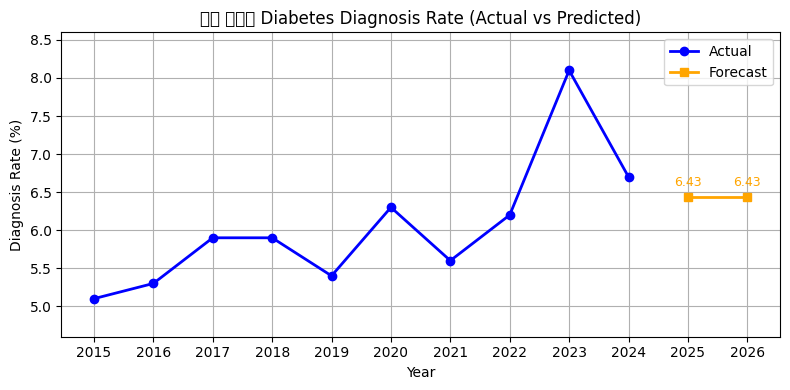

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import urllib.parse
import matplotlib.pyplot as plt
import warnings

# 경고 무시
warnings.filterwarnings('ignore', category=UserWarning)

# ✅ GitHub raw 파일 경로 (수정됨)
BASE_URL = "https://raw.githubusercontent.com/SJG0510/ML-Project/data/"

# 건강 지표별 CSV 파일명 매핑
FILES = {
    '흡연율': '흡연률_표준화율.csv',
    '고위험음주율': '고위험음주율_표준화율.csv',
    '비만율': '비만율_표준화율.csv',
    '스트레스율': '스트레스율_표준화율.csv',
    '우울증상율': '우울증상율_표준화율.csv',
    '당뇨병진단율': '당뇨병진단율_표준화율.csv',
}
FEATURE_COLS = list(FILES.keys())[:-1]
TARGET_COL = '당뇨병진단율'

def load_and_prepare_data():
    """
    GitHub에서 각 CSV를 불러와 long 형태로 변환하고 병합
    """
    dfs = []
    for col, fname in FILES.items():
        url = BASE_URL + urllib.parse.quote(fname)
        try:
            df = pd.read_csv(url, encoding='utf-8-sig')
        except UnicodeDecodeError:
            df = pd.read_csv(url, encoding='cp949')
        year_cols = [c for c in df.columns if c.isdigit()]
        df_long = df.melt(
            id_vars=['시도', '시군구'],
            value_vars=year_cols,
            var_name='year',
            value_name=col
        )
        df_long['year'] = df_long['year'].astype(int)
        dfs.append(df_long[['시도', '시군구', 'year', col]])
    from functools import reduce
    return reduce(lambda left, right: pd.merge(
        left, right,
        on=['시도', '시군구', 'year'],
        how='inner'
    ), dfs)

def train_model(df):
    """
    결측치 제거 후 선형 회귀 모델 학습
    """
    df_clean = df.dropna(subset=FEATURE_COLS + [TARGET_COL])
    X = df_clean[FEATURE_COLS]
    y = df_clean[TARGET_COL]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    print(f"결정계수(R²): {r2_score(y, y_pred):.3f}")
    print(f"평균제곱오차(MSE): {mean_squared_error(y, y_pred):.3f}")
    return model

def predict_future(model, last_row, future_years):
    """
    마지막 연도의 특성값으로 미래 예측
    """
    df_new = pd.DataFrame(
        np.repeat(last_row.values, len(future_years), axis=0),
        columns=FEATURE_COLS,
        index=future_years
    )
    preds = model.predict(df_new)
    return dict(zip(future_years, np.round(preds, 2)))

def visualize(actual_df, preds, region):
    """
    2015년 이후의 실제값과 예측값을 시각화 (예측값 텍스트는 주황색)
    """
    df_recent = actual_df[actual_df['year'] >= 2015]
    years_act = df_recent['year'].tolist()
    vals_act = list(map(float, df_recent[TARGET_COL]))
    years_pred = list(preds.keys())
    vals_pred = list(map(float, preds.values()))

    plt.figure(figsize=(8, 4))
    plt.plot(years_act, vals_act, marker='o', markersize=6, linewidth=2, label='Actual', color='blue')
    plt.plot(years_pred, vals_pred, marker='s', markersize=6, linewidth=2, label='Forecast', color='orange')

    # 예측값 텍스트 주황색 표시
    for x, y in zip(years_pred, vals_pred):
        plt.text(x, y + 0.15, f'{y:.2f}', ha='center', fontsize=9, color='orange')

    all_vals = vals_act + vals_pred
    plt.ylim(min(all_vals) - 0.5, max(all_vals) + 0.5)

    plt.title(f"{region} Diabetes Diagnosis Rate (Actual vs Predicted)")
    plt.xlabel('Year')
    plt.ylabel('Diagnosis Rate (%)')
    plt.xticks(years_act + years_pred)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # 1. 데이터 로드
    data = load_and_prepare_data()

    # 2. 시도 선택
    provinces = sorted(data['시도'].unique())
    print("사용 가능한 시도:", ", ".join(provinces))
    province = input("예측할 시도를 입력하세요: ").strip()
    if province not in provinces:
        print("잘못된 시도입니다.")
        exit(1)

    # 3. 시군구 선택
    districts = sorted(data[data['시도'] == province]['시군구'].unique())
    print(f"{province}의 선택 가능한 시군구:", ", ".join(districts))
    district = input("예측할 시군구를 입력하세요: ").strip()
    if district not in districts:
        print("잘못된 시군구입니다.")
        exit(1)

    # 4. 전체 연도 데이터 필터링
    df_reg = data[
        (data['시도'] == province) & (data['시군구'] == district)
    ].sort_values('year')

    if df_reg.empty:
        print("해당 지역의 데이터가 없습니다.")
        exit(1)

    # 5. 모델 학습
    model = train_model(df_reg)

    # 6. 마지막 연도 특성값 기반 예측
    last_row = df_reg[df_reg['year'] == df_reg['year'].max()][FEATURE_COLS]
    future_years = [2025, 2026]
    preds = predict_future(model, last_row, future_years)

    # 7. 결과 출력
    print(f"\n실제 ({df_reg['year'].min()}~{df_reg['year'].max()}):")
    for y, v in zip(df_reg['year'], df_reg[TARGET_COL]):
        print(f"{y}년: {v}%")

    print("\n예측 (2025~2026):")
    for y, v in preds.items():
        print(f"{y}년: {v}%")

    # 8. 시각화
    visualize(df_reg, preds, f"{province} {district}")

SARIMAX 예측

사용 가능한 시도: 강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 제주, 충남, 충북
예측할 시도를 선택하세요 ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']: 서울
서울의 선택 가능한 시군구: 강남구, 강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 송파구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중구, 중랑구
예측할 시군구를 선택하세요 ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구']: 강남구
                               SARIMAX Results                                
Dep. Variable:                 당뇨병진단율   No. Observations:                    7
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  28.520
Date:                Wed, 04 Jun 2025   AIC                            -41.041
Time:                        06:42:14   BIC                            -45.950
Sample:                             0   HQIC                      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


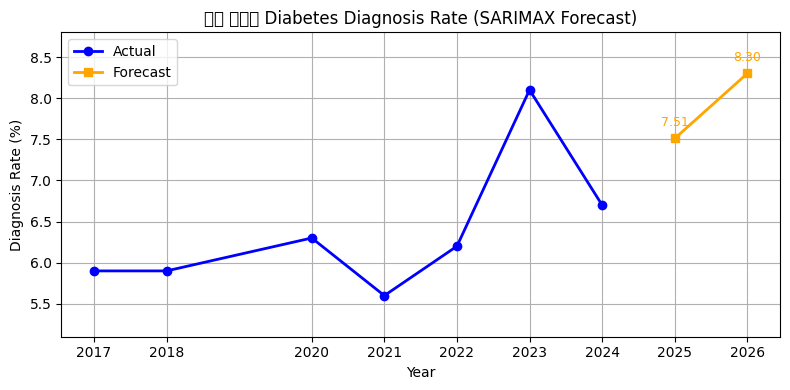

In [ ]:
import pandas as pd
import numpy as np
import urllib.parse
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 경고 무시
warnings.filterwarnings('ignore', category=UserWarning)

# ✅ 최신 GitHub raw 주소 (ML-Project 브랜치)
BASE_URL = "https://raw.githubusercontent.com/SJG0510/ML-Project/data/"

FILES = {
    '흡연율':       '흡연률_표준화율.csv',
    '고위험음주율':  '고위험음주율_표준화율.csv',
    '비만율':       '비만율_표준화율.csv',
    '스트레스율':    '스트레스율_표준화율.csv',
    '우울증상율':    '우울증상율_표준화율.csv',
    '당뇨병진단율':  '당뇨병진단율_표준화율.csv',
}
FEATURE_COLS = list(FILES.keys())[:-1]
TARGET_COL = '당뇨병진단율'

def load_and_prepare_data():
    """
    GitHub ML-Project 브랜치에서 각 CSV를 불러와 long 형태로 변환하고 병합
    """
    dfs = []
    for col, fname in FILES.items():
        url = BASE_URL + urllib.parse.quote(fname)
        try:
            df = pd.read_csv(url, encoding='utf-8-sig')
        except UnicodeDecodeError:
            df = pd.read_csv(url, encoding='cp949')

        year_cols = [c for c in df.columns if c.isdigit()]
        df_long = df.melt(
            id_vars=['시도', '시군구'],
            value_vars=year_cols,
            var_name='year',
            value_name=col
        )
        df_long['year'] = df_long['year'].astype(int)
        dfs.append(df_long[['시도', '시군구', 'year', col]])

    from functools import reduce
    return reduce(lambda a, b: pd.merge(a, b, on=['시도', '시군구', 'year']), dfs)

def fit_sarimax(df_region):
    """
    SARIMAX 모델 학습
    """
    df_clean = df_region.dropna(subset=FEATURE_COLS + [TARGET_COL]).copy()
    df_clean[FEATURE_COLS] = df_clean[FEATURE_COLS].apply(pd.to_numeric, errors='coerce')
    df_clean[TARGET_COL] = pd.to_numeric(df_clean[TARGET_COL], errors='coerce')
    df_clean = df_clean.dropna(subset=FEATURE_COLS + [TARGET_COL])

    endog = df_clean[TARGET_COL]
    exog = df_clean[FEATURE_COLS]

    model = SARIMAX(
        endog,
        exog=exog,
        order=(1, 1, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    print(res.summary())
    return res, df_clean

def forecast_sarimax(res, df_clean, future_years):
    """
    SARIMAX 모델로 미래 예측
    """
    last_exog = df_clean[FEATURE_COLS].iloc[-1].astype(float).values.reshape(1, -1)
    future_exog = np.repeat(last_exog, len(future_years), axis=0)
    pred = res.get_forecast(steps=len(future_years), exog=future_exog)
    mean_forecast = pred.predicted_mean.round(2)
    return dict(zip(future_years, mean_forecast))

def visualize_ts(df_region, preds, region):
    """
    시계열 실제값 vs 예측값 시각화
    """
    years_act = df_region['year'].tolist()
    vals_act = df_region[TARGET_COL].tolist()
    years_pred = list(preds.keys())
    vals_pred = list(preds.values())

    plt.figure(figsize=(8, 4))
    plt.plot(years_act, vals_act, marker='o', markersize=6, linewidth=2, label='Actual', color='blue')
    plt.plot(years_pred, vals_pred, marker='s', markersize=6, linewidth=2, label='Forecast', color='orange')

    for x, y in zip(years_pred, vals_pred):
        plt.text(x, y + 0.15, f'{y:.2f}', ha='center', fontsize=9, color='orange')

    all_vals = vals_act + vals_pred
    plt.ylim(min(all_vals) - 0.5, max(all_vals) + 0.5)

    plt.title(f"{region} Diabetes Diagnosis Rate (SARIMAX Forecast)")
    plt.xlabel('Year')
    plt.ylabel('Diagnosis Rate (%)')
    plt.xticks(years_act + years_pred)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # 1. 데이터 로드
    data = load_and_prepare_data()

    # 2. 시도 선택
    provinces = sorted(data['시도'].unique())
    print("사용 가능한 시도:", ", ".join(provinces))
    province = input(f"예측할 시도를 선택하세요 {provinces}: ").strip()
    if province not in provinces:
        print("잘못된 시도입니다.")
        exit(1)

    # 3. 시군구 선택
    districts = sorted(data[data['시도'] == province]['시군구'].unique())
    print(f"{province}의 선택 가능한 시군구:", ", ".join(districts))
    district = input(f"예측할 시군구를 선택하세요 {districts}: ").strip()
    if district not in districts:
        print("잘못된 시군구입니다.")
        exit(1)

    # 4. 해당 지역 데이터 필터링 및 연도 정렬
    df_region = data[
        (data['시도'] == province) &
        (data['시군구'] == district)
    ].sort_values('year')

    if df_region.empty:
        print("해당 지역의 데이터가 없습니다.")
        exit(1)

    # 5. SARIMAX 모델 학습
    res, df_clean = fit_sarimax(df_region)

    # 6. 미래(2025, 2026) 예측
    future_years = [2025, 2026]
    preds = forecast_sarimax(res, df_clean, future_years)

    # 7. 결과 출력
    print(f"\n실제 ({df_clean['year'].min()}~{df_clean['year'].max()}):")
    for y, v in zip(df_clean['year'], df_clean[TARGET_COL]):
        print(f"{y}년: {v}%")

    print("\n예측 (2025~2026):")
    for y, v in preds.items():
        print(f"{y}년: {v}%")

    # 8. 시각화
    visualize_ts(df_clean, preds, f"{province} {district}")

Random Forest 예측

사용 가능한 시도: 강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 제주, 충남, 충북
예측할 시도를 입력하세요: 서울
서울의 선택 가능한 시군구: 강남구, 강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 송파구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중구, 중랑구
예측할 시군구를 입력하세요: 강남구
결정계수(R²): 0.833
평균제곱오차(MSE): 0.100

실제 (2008~2024):
2008년: 4.4%
2009년: 6.0%
2010년: 6.3%
2011년: 7.2%
2012년: 7.4%
2013년: 6.1%
2014년: 6.4%
2015년: 5.1%
2016년: 5.3%
2017년: 5.9%
2018년: 5.9%
2019년: 5.4%
2020년: 6.3%
2021년: 5.6%
2022년: 6.2%
2023년: 8.1%
2024년: 6.7%

예측 (2025~2026):
2025년: 6.49%
2026년: 6.49%


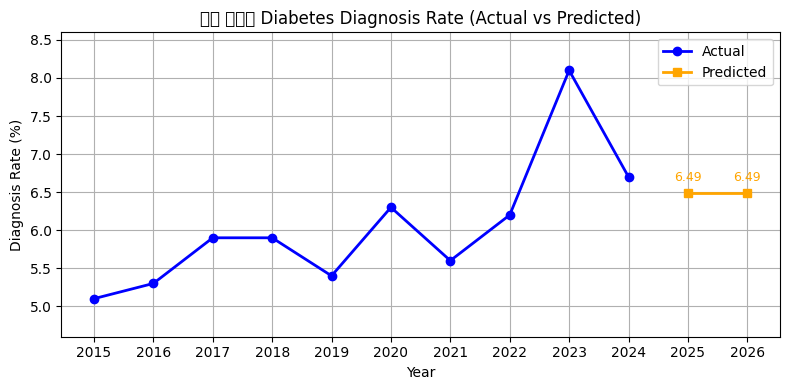

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import urllib.parse
import matplotlib.pyplot as plt
import warnings

# 경고 무시
warnings.filterwarnings('ignore', category=UserWarning)

# ✅ 변경된 GitHub raw 주소 (ML-Project 브랜치)
BASE_URL = "https://raw.githubusercontent.com/SJG0510/ML-Project/data/"

# 건강 지표별 파일 매핑
FILES = {
    '흡연율':       '흡연률_표준화율.csv',
    '고위험음주율':  '고위험음주율_표준화율.csv',
    '비만율':       '비만율_표준화율.csv',
    '스트레스율':    '스트레스율_표준화율.csv',
    '우울증상율':    '우울증상율_표준화율.csv',
    '당뇨병진단율':  '당뇨병진단율_표준화율.csv',
}
FEATURE_COLS = list(FILES.keys())[:-1]
TARGET_COL = '당뇨병진단율'

def load_and_prepare_data():
    dfs = []
    for col, fname in FILES.items():
        url = BASE_URL + urllib.parse.quote(fname)
        try:
            df = pd.read_csv(url, encoding='utf-8-sig')
        except UnicodeDecodeError:
            df = pd.read_csv(url, encoding='cp949')
        year_cols = [c for c in df.columns if c.isdigit()]
        df_long = df.melt(
            id_vars=['시도', '시군구'],
            value_vars=year_cols,
            var_name='year',
            value_name=col
        )
        df_long['year'] = df_long['year'].astype(int)
        dfs.append(df_long[['시도', '시군구', 'year', col]])
    from functools import reduce
    return reduce(lambda left, right: pd.merge(
        left, right, on=['시도', '시군구', 'year'], how='inner'
    ), dfs)

def train_model(df):
    df_clean = df.dropna(subset=FEATURE_COLS + [TARGET_COL])
    X = df_clean[FEATURE_COLS]
    y = df_clean[TARGET_COL]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    y_pred = model.predict(X)
    print(f"결정계수(R²): {r2_score(y, y_pred):.3f}")
    print(f"평균제곱오차(MSE): {mean_squared_error(y, y_pred):.3f}")
    return model

def predict_future(model, last_row, future_years):
    df_new = pd.DataFrame(
        np.repeat(last_row.values, len(future_years), axis=0),
        columns=FEATURE_COLS,
        index=future_years
    )
    preds = model.predict(df_new)
    return dict(zip(future_years, np.round(preds, 2)))

def visualize(actual_df, preds, region):
    """
    2015년 이후 실제값과 예측값을 시각화하며 예측값 위에 값 표시
    """
    df_recent = actual_df[actual_df['year'] >= 2015]
    years_act = df_recent['year'].tolist()
    vals_act = df_recent[TARGET_COL].tolist()
    years_pred = list(preds.keys())
    vals_pred = list(preds.values())

    plt.figure(figsize=(8, 4))
    plt.plot(years_act, vals_act, marker='o', markersize=6, linewidth=2, label='Actual', color='blue')
    plt.plot(years_pred, vals_pred, marker='s', markersize=6, linewidth=2, label='Predicted', color='orange')

    for x, y in zip(years_pred, vals_pred):
        plt.text(x, y + 0.15, f'{y:.2f}', ha='center', fontsize=9, color='orange')

    all_vals = vals_act + vals_pred
    plt.ylim(min(all_vals) - 0.5, max(all_vals) + 0.5)

    plt.title(f"{region} Diabetes Diagnosis Rate (Actual vs Predicted)")
    plt.xlabel('Year')
    plt.ylabel('Diagnosis Rate (%)')
    plt.xticks(years_act + years_pred)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # 데이터 로드
    data = load_and_prepare_data()

    # 사용자 입력
    provinces = sorted(data['시도'].unique())
    print("사용 가능한 시도:", ", ".join(provinces))
    province = input("예측할 시도를 입력하세요: ").strip()
    if province not in provinces:
        print("잘못된 시도입니다.")
        exit(1)

    districts = sorted(data[data['시도'] == province]['시군구'].unique())
    print(f"{province}의 선택 가능한 시군구:", ", ".join(districts))
    district = input("예측할 시군구를 입력하세요: ").strip()
    if district not in districts:
        print("잘못된 시군구입니다.")
        exit(1)

    df_reg = data[
        (data['시도'] == province) &
        (data['시군구'] == district)
    ].sort_values('year')

    if df_reg.empty:
        print("해당 지역의 데이터가 없습니다.")
        exit(1)

    # 모델 학습
    model = train_model(df_reg)

    # 미래 예측
    last_row = df_reg[df_reg['year'] == df_reg['year'].max()][FEATURE_COLS]
    future_years = [2025, 2026]
    preds = predict_future(model, last_row, future_years)

    # 결과 출력
    print(f"\n실제 ({df_reg['year'].min()}~{df_reg['year'].max()}):")
    for y, v in zip(df_reg['year'], df_reg[TARGET_COL]):
        print(f"{y}년: {v}%")

    print("\n예측 (2025~2026):")
    for y, v in preds.items():
        print(f"{y}년: {v}%")

    # 시각화
    visualize(df_reg, preds, f"{province} {district}")

ARIMAX 예측

사용 가능한 시도: 강원, 경기, 경남, 경북, 광주, 대구, 대전, 부산, 서울, 세종, 울산, 인천, 전남, 전북, 제주, 충남, 충북
예측할 시도를 입력하세요: 서울
서울의 선택 가능한 시군구: 강남구, 강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, 도봉구, 동대문구, 동작구, 마포구, 서대문구, 서초구, 성동구, 성북구, 송파구, 양천구, 영등포구, 용산구, 은평구, 종로구, 중구, 중랑구
예측할 시군구를 입력하세요: 강남구
                               SARIMAX Results                                
Dep. Variable:                 당뇨병진단율   No. Observations:                    7
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  15.709
Date:                Wed, 04 Jun 2025   AIC                            -15.418
Time:                        06:44:07   BIC                            -17.084
Sample:                             0   HQIC                           -22.087
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

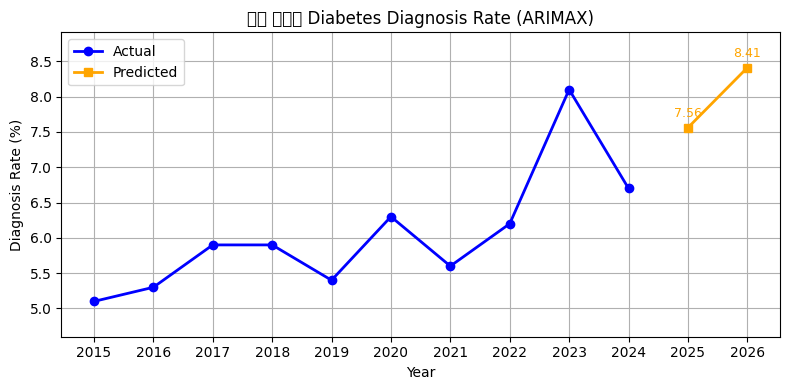

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import urllib.parse
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

BASE_URL = "https://raw.githubusercontent.com/SJG0510/Private-Project-Practice/data/"

FILES = {
    '흡연율':       '흡연률_표준화율.csv',
    '고위험음주율':  '고위험음주율_표준화율.csv',
    '비만율':       '비만율_표준화율.csv',
    '스트레스율':    '스트레스율_표준화율.csv',
    '우울증상율':    '우울증상율_표준화율.csv',
    '당뇨병진단율':  '당뇨병진단율_표준화율.csv',
}
FEATURE_COLS = list(FILES.keys())[:-1]
TARGET_COL = '당뇨병진단율'

def load_and_prepare_data():
    dfs = []
    for col, fname in FILES.items():
        url = BASE_URL + urllib.parse.quote(fname)
        try:
            df = pd.read_csv(url, encoding='utf-8-sig')
        except UnicodeDecodeError:
            df = pd.read_csv(url, encoding='cp949')
        year_cols = [c for c in df.columns if c.isdigit()]
        df_long = df.melt(
            id_vars=['시도', '시군구'],
            value_vars=year_cols,
            var_name='year',
            value_name=col
        )
        df_long['year'] = df_long['year'].astype(int)
        dfs.append(df_long[['시도', '시군구', 'year', col]])
    from functools import reduce
    data = reduce(lambda l, r: pd.merge(l, r, on=['시도', '시군구', 'year'], how='inner'), dfs)
    return data

def train_arimax(df):
    df_clean = df.dropna(subset=FEATURE_COLS + [TARGET_COL])
    y = df_clean[TARGET_COL].astype(float)
    X = df_clean[FEATURE_COLS].astype(float)
    model = ARIMA(endog=y, exog=X, order=(1, 1, 1))
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

def predict_future(model_fit, last_row, future_years):
    last_row = last_row.astype(float)
    future_X = pd.DataFrame(
        np.repeat(last_row.values, len(future_years), axis=0),
        columns=FEATURE_COLS
    )
    forecast = model_fit.forecast(steps=len(future_years), exog=future_X)
    return dict(zip(future_years, np.round(forecast, 2)))

def visualize(actual_df, preds, region):
    recent_df = actual_df[actual_df['year'] >= 2015]
    years_act = recent_df['year'].tolist()
    vals_act = list(map(float, recent_df[TARGET_COL]))
    years_pred = list(preds.keys())
    vals_pred = list(map(float, preds.values()))

    plt.figure(figsize=(8, 4))
    plt.plot(years_act, vals_act, marker='o', markersize=6, linewidth=2, label='Actual', color='blue')
    plt.plot(years_pred, vals_pred, marker='s', markersize=6, linewidth=2, label='Predicted', color='orange')

    for x, y in zip(years_pred, vals_pred):
        plt.text(x, y + 0.15, f'{y:.2f}', ha='center', fontsize=9, color='orange')

    all_vals = vals_act + vals_pred
    plt.ylim(min(all_vals) - 0.5, max(all_vals) + 0.5)

    plt.title(f"{region} Diabetes Diagnosis Rate (ARIMAX)")
    plt.xlabel('Year')
    plt.ylabel('Diagnosis Rate (%)')
    plt.xticks(years_act + years_pred)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    data = load_and_prepare_data()

    provinces = sorted(data['시도'].unique())
    print("사용 가능한 시도:", ", ".join(provinces))
    province = input("예측할 시도를 입력하세요: ").strip()
    if province not in provinces:
        print("잘못된 시도입니다.")
        exit(1)

    districts = sorted(data[data['시도'] == province]['시군구'].unique())
    print(f"{province}의 선택 가능한 시군구:", ", ".join(districts))
    district = input("예측할 시군구를 입력하세요: ").strip()
    if district not in districts:
        print("잘못된 시군구입니다.")
        exit(1)

    df_reg = data[
        (data['시도'] == province) &
        (data['시군구'] == district)
    ].sort_values('year')

    if df_reg.empty:
        print("해당 지역의 데이터가 없습니다.")
        exit(1)

    model_fit = train_arimax(df_reg)
    last_row = df_reg[df_reg['year'] == df_reg['year'].max()][FEATURE_COLS]
    future_years = [2025, 2026]
    preds = predict_future(model_fit, last_row, future_years)

    print(f"\n실제 ({df_reg['year'].min()}~{df_reg['year'].max()}):")
    for y, v in zip(df_reg['year'], df_reg[TARGET_COL]):
        print(f"{y}년: {v}%")

    print("\n예측 (2025~2026):")
    for y, v in preds.items():
        print(f"{y}년: {v}%")

    visualize(df_reg, preds, f"{province} {district}")